# Exploratory Data Analysis

Explore general aspects about the data from an historical perspective and also looking at the most recent batch

In [5]:
from database_settings.spark_utilities import get_spark_df, spark_session

In [6]:
from pyspark.sql.functions import substring, to_date, col, lpad
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
# Spark session
spark = spark_session()

In [10]:
# Get the data into a spark dataframe
path = '/thesis/peru/exports/*.parquet'
df = get_spark_df(spark_session=spark, file_path=path)

## Historical Data (all batches published)

In [11]:
# Get attributes
print('Number of attributes: ' + str(len(df.columns)))
# Show all possible keys
df.printSchema()

Number of attributes: 46
root
 |-- CADU: string (nullable = true)
 |-- FANO: string (nullable = true)
 |-- NDCL: string (nullable = true)
 |-- FNUM: long (nullable = true)
 |-- FEMB: long (nullable = true)
 |-- FECH_RECEP: long (nullable = true)
 |-- NDCLREG: string (nullable = true)
 |-- FREG: long (nullable = true)
 |-- FANOREG: string (nullable = true)
 |-- CAGE: string (nullable = true)
 |-- TDOC: string (nullable = true)
 |-- NDOC: string (nullable = true)
 |-- DNOMBRE: string (nullable = true)
 |-- CPAIDES: string (nullable = true)
 |-- CPUEDES: string (nullable = true)
 |-- CVIATRA: string (nullable = true)
 |-- CUNITRA: string (nullable = true)
 |-- CEMPTRA: string (nullable = true)
 |-- DMAT: string (nullable = true)
 |-- NCON: string (nullable = true)
 |-- CENTFIN: string (nullable = true)
 |-- CALM: string (nullable = true)
 |-- DNOMPRO: string (nullable = true)
 |-- DDIRPRO: string (nullable = true)
 |-- DK: string (nullable = true)
 |-- DK2: string (nullable = true)
 |-- N

In [12]:
# Verify batches
df2 = df.groupBy("BATCH_WEEK")\
    .count()\
    .withColumn("date_str", substring("BATCH_WEEK", 3, 7)) \
    .withColumn("date", to_date("date_str", "ddMMyy")) \
    .orderBy("date")\
    .select(['date', 'count'])\
    .toPandas()

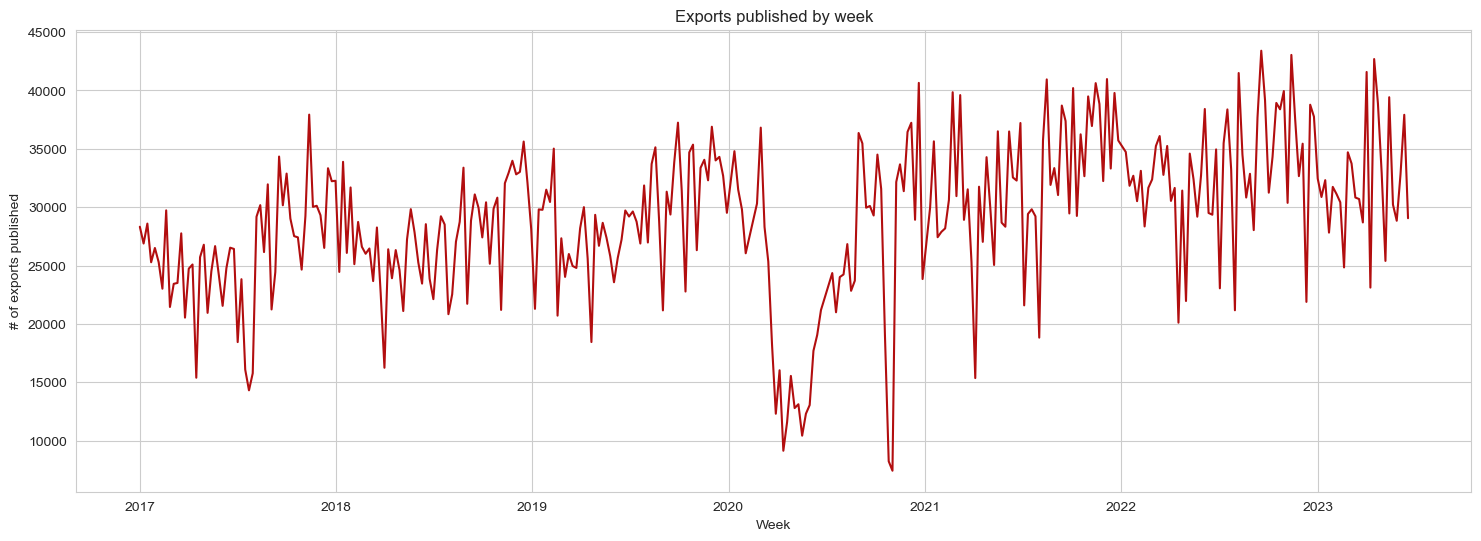

In [15]:
plt.figure(figsize=(18, 6))
plt.plot(df2["date"], df2["count"], color='#B20E0F')
plt.xlabel("Week")
plt.ylabel("# of exports published")
plt.title("Exports published by week")
plt.show()

In [18]:
# Get all possible headings in the data
hs = df.select('PART_NANDI')\
    .distinct()\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .select('HS')\
    .toPandas()

In [19]:
print('The total number of headings in the data is: '+str(len(hs)))

The total number of headings in the data is: 6511


In [20]:
# Headings to work with:
# 07XXXXXXXX: Hortalizas, plantas, raíces y tubérculos alimenticios
# 08XXXXXXXX: Frutas y frutos comestibles; cortezas de agrios (cítricos), melones o sandías.

hs_to_work = ['07', '08']
hs[hs['HS'].str.startswith(tuple(hs_to_work))].sort_values(by='HS', ascending= True)

,HS
1441,0701100000
4168,0701900000
1625,0702000000
2387,0703100000
314,0703201000
...,...
5415,0813300000
2867,0813400000
5005,0813500000
449,0814001000


## Last batch published

In [21]:
# Last batch
last_batch_week = df.select("BATCH_WEEK")\
    .distinct() \
    .withColumn("date_str", substring("BATCH_WEEK", 3, 7)) \
    .withColumn("date", to_date("date_str", "ddMMyy")) \
    .orderBy("date", ascending=False)\
    .limit(1)\
    .select('BATCH_WEEK')
# Get week code
last_batch_week = last_batch_week.head()[0]
# Get the dataframe
df_last = df.filter(df.BATCH_WEEK == last_batch_week)

In [22]:
# Get count of new registers
print('Number of registers: ' + str(df_last.count()))
# Get attributes
print('Number of attributes: ' + str(len(df_last.columns)))
# Visualize the attributes
df_last.printSchema()

Number of registers: 29054
Number of attributes: 46
root
 |-- CADU: string (nullable = true)
 |-- FANO: string (nullable = true)
 |-- NDCL: string (nullable = true)
 |-- FNUM: long (nullable = true)
 |-- FEMB: long (nullable = true)
 |-- FECH_RECEP: long (nullable = true)
 |-- NDCLREG: string (nullable = true)
 |-- FREG: long (nullable = true)
 |-- FANOREG: string (nullable = true)
 |-- CAGE: string (nullable = true)
 |-- TDOC: string (nullable = true)
 |-- NDOC: string (nullable = true)
 |-- DNOMBRE: string (nullable = true)
 |-- CPAIDES: string (nullable = true)
 |-- CPUEDES: string (nullable = true)
 |-- CVIATRA: string (nullable = true)
 |-- CUNITRA: string (nullable = true)
 |-- CEMPTRA: string (nullable = true)
 |-- DMAT: string (nullable = true)
 |-- NCON: string (nullable = true)
 |-- CENTFIN: string (nullable = true)
 |-- CALM: string (nullable = true)
 |-- DNOMPRO: string (nullable = true)
 |-- DDIRPRO: string (nullable = true)
 |-- DK: string (nullable = true)
 |-- DK2: stri

In [23]:
# Aggregate exports by day
df_last_agg = df_last.groupBy("FEMB")\
    .count()\
    .withColumn("date", to_date("FEMB", "yyyyMMdd")) \
    .orderBy("date")\
    .select(['date', 'count'])

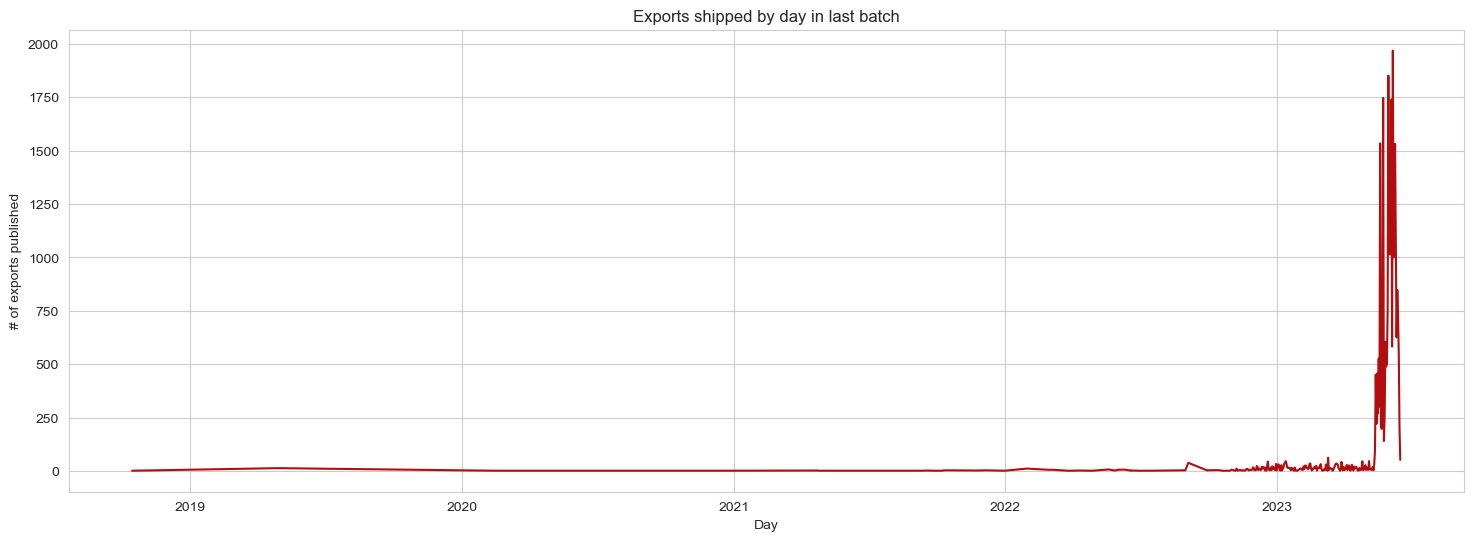

In [32]:
# Plot exports by day in batch
plt.figure(figsize=(18, 6))
plt.plot(df_last_agg.toPandas()["date"], df_last_agg.toPandas()["count"], color='#B20E0F')
plt.xlabel("Day")
plt.ylabel("# of exports published")
plt.title("Exports shipped by day in last batch")
plt.show()

In [25]:
# Get starting and end dates of the batch's week
week_start_date = datetime.strptime(last_batch_week[0:2]+last_batch_week[4:8], '%d%m%y').date()
week_end_date = datetime.strptime(last_batch_week[2:8], '%d%m%y').date()

In [26]:
# Make a comparison between regular and outdated registrations inside the batch (consider a regular registration one whose shipment date 'FEMB' falls inside the batch's week range)
df_last_reg_out = df_last\
    .withColumn("regular", ((to_date(col('FEMB'), 'yyyyMMdd') >= week_start_date) & (to_date(col('FEMB'), 'yyyyMMdd') <= week_end_date)))\
    .select(['regular'])\
    .toPandas()

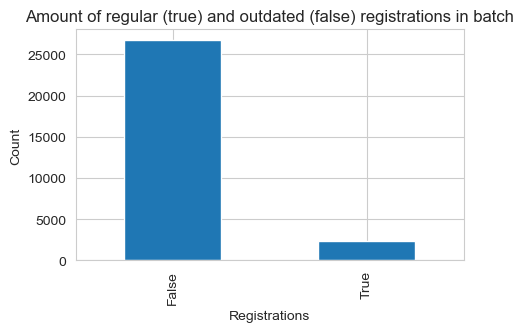

In [27]:
plt.figure(figsize=(5, 3))
df_last_reg_out['regular'].value_counts().plot(kind='bar')
plt.xlabel('Registrations')
plt.ylabel('Count')
plt.title('Amount of regular (true) and outdated (false) registrations in batch')
plt.show()